In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import minimize

filename = "Number_3.txt"
data =  np.array(open(filename).read().split()).astype(float)
data = np.sort(data)

print(f"Выборочное среднее: {np.mean(data)}")
print(f"Выборочная дисперсия: {np.var(data, ddof=1)}")
print(f"Выборочный коэффициент ассиметрии : {st.skew(data, bias=False)}")
print(f"Коэффицеинт эксцесса: {st.kurtosis(data, bias=False)}")



Выборочное среднее: 3.867406990333334
Выборочная дисперсия: 6.814024540508929
Выборочный коэффициент ассиметрии : 1.4101517630007825
Коэффицеинт эксцесса: 2.504227644811291


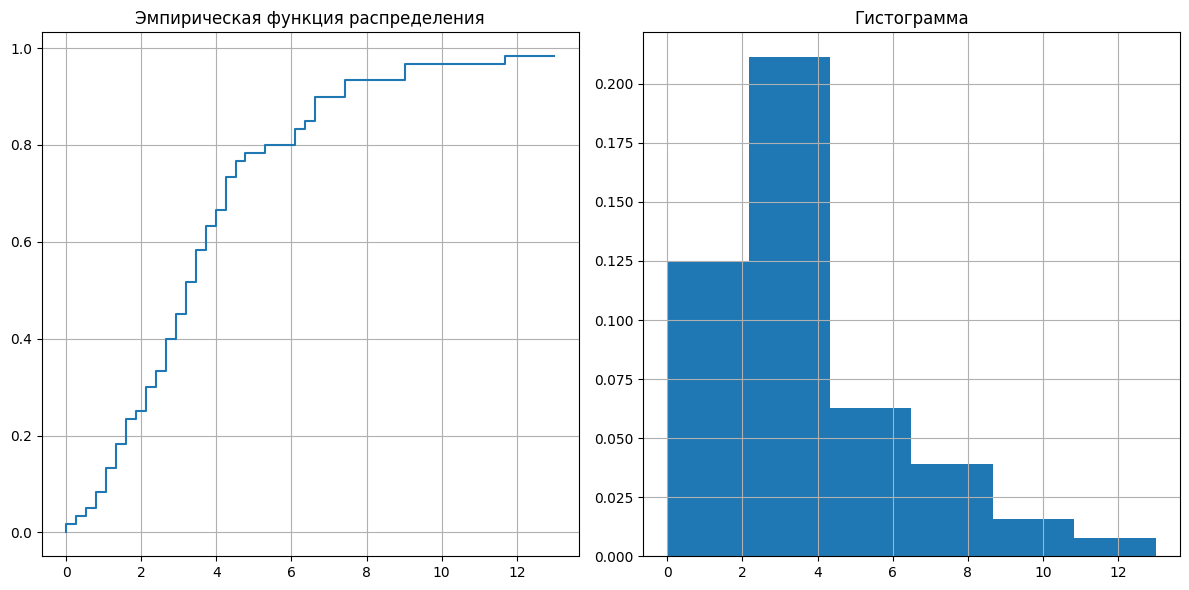

In [23]:
def empirical_df(x, sample: np.ndarray):
    return sum(sample < x)/len(sample)

x_emp = np.linspace(round(data[0]), round(data[-1]), 50)
y_emp = np.fromiter(map(lambda elem: empirical_df(elem, data), x_emp), dtype=float)

f, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].grid()
ax[0].step(x_emp,y_emp)
ax[0].set_title("Эмпирическая функция распределения")
k = 7
bins = list(np.linspace(round(data[0]), round(data[-1]), k))


ax[1].grid()
ax[1].hist(data,bins= bins, density=True)
ax[1].set_title("Гистограмма")
f.tight_layout()


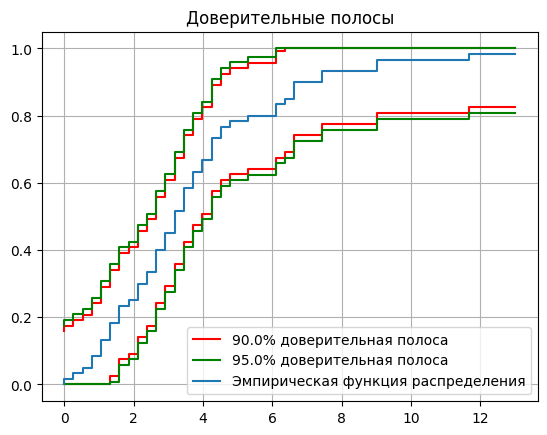

In [4]:

left = lambda x, quant: max(0, empirical_df(x, data) - quant / np.sqrt(len(data)))
right = lambda x, quant: min(1, empirical_df(x, data) + quant / np.sqrt(len(data)))

quantile = lambda alpha: np.sqrt(np.log((1 - alpha) / 2) * (-1/2))

for gamma, plt_color in zip([0.9, 0.95], ['r', 'g']):
    quant = quantile(gamma)
    left_border = np.fromiter(map(lambda x: left(x, quant), x_emp), dtype=float)
    right_border = np.fromiter(map(lambda x: right(x, quant), x_emp), dtype=float)
    plt.step(x_emp, left_border, color = plt_color, label = f"{gamma * 100}% доверительная полоса")
    plt.step(x_emp, right_border, color = plt_color)

plt.grid()
plt.step(x_emp, y_emp, label = "Эмпирическая функция распределения", color = 'tab:blue')
plt.title("Доверительные полосы")
plt.legend()


In [21]:
def distr_cdf(distr, *args, **kwargs):
    return getattr(distr, 'cdf')(*args, **kwargs)


def get_p(distr, *args, **kwargs):
    return [distr_cdf(distr, b, *args, **kwargs) - distr_cdf(distr, a, *args, **kwargs) for a,b in zip(bins, bins[1:])]

def get_m():
    return [sum(a < x <= b for x in data) for a,b in zip(bins, bins[1:])]


def chi2_Fishser(distr, *args, **kwargs):
    p = get_p(distr, *args, **kwargs)
    
    m = get_m()
    n = len(data)
    return sum((mi - n * pi)**2 / (n * pi) for mi, pi in zip(m, p))


chi2 = lambda args:chi2_Fishser(st.gamma, *args)
params = st.gamma.fit(data)
res = minimize(chi2, params, method='Nelder-Mead')
print(f"Вычисленное значение {res.fun}")
print(f"Квантиль {st.chi2.ppf(0.95, k  -2 - 1)}")    

Вычисленное значение 0.2803092563497795
Квантиль 9.487729036781154


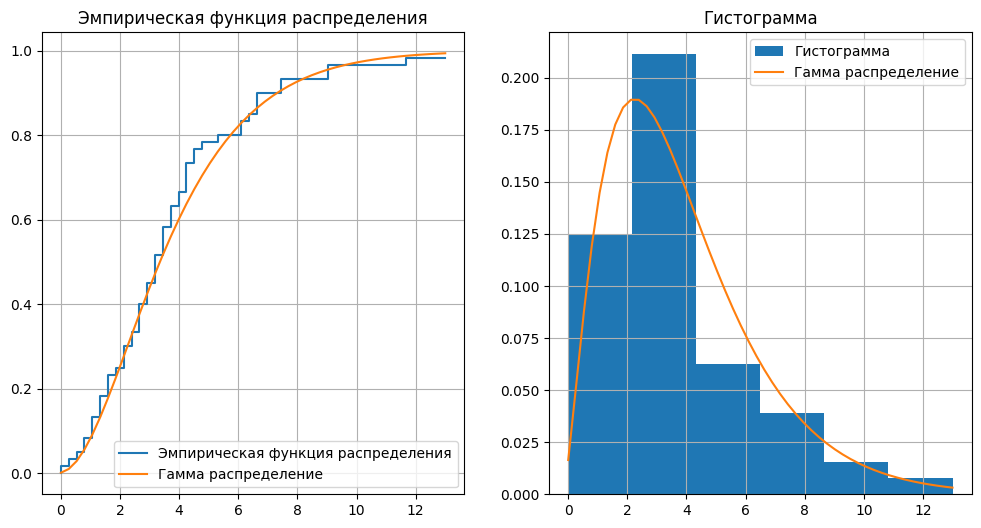

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].grid()
ax[0].step(x_emp,y_emp, label='Эмпирическая функция распределения')
ax[0].plot(x_emp, st.beta.cdf(x_emp, *params), label="Гамма распределение")
ax[0].set_title("Эмпирическая функция распределения")
ax[0].legend()

ax[1].grid()
ax[1].hist(data,bins= bins, density=True, label = "Гистограмма")
ax[1].plot(x_emp, st.beta.pdf(x_emp, *params), label="Гамма распределение")
ax[1].set_title("Гистограмма")
ax[1].legend()